## Introduction
The name of this project is Ballot paper classification. In this project, our task is to classify the ballot paper to one of the 48 classes where each label represents each political party. We have two seperate datasets for train and test. 



## Import libraries
Let's import some important libraries we will be using throughout this project.

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image

from tensorflow.keras.models import Model

%matplotlib inline

## Mount drive
Since, our dataset is very huge. So, we need to mount our drive for uploading dataset to our current directory.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Path to My Drive
drive_path = 'drive/My Drive/'

## Preparing dataset

Let's create `train` and `test` folders for loading the dataset.

In [0]:
# Creating directory for train and test 
!mkdir train
!mkdir test

In [0]:
# Unzipping Train file in train folder
!tar -xf drive/My\ Drive/Train.tar.gz -C train

In [0]:
# Unzipping Train file in train folder
!tar -xf drive/My\ Drive/Test.tar.gz -C test

Great! Let's see whether data has been loaded or not with following commands.

In [0]:
# number of images in the training set
!ls train/testset | wc -l

9600


In [0]:
# number of images in the testing set
!ls test/testset | wc -l

2609


In [0]:
# Path to train and test images
TRAIN_DATA_PATH = 'train/testset'
TEST_DATA_PATH = 'test/testset'

In [0]:
# Path to train and test csv files
TRAIN_CSV_PATH = 'train/testset.csv'
TEST_CSV_PATH = 'test/testset.csv'

## Load dataset
Now, let's load the `csv` dataset of train and test folders.


In [0]:
import pandas as pd
import numpy as np

df_train = pd.read_csv(TRAIN_CSV_PATH, dtype=str) # Load train dataframe
df_test = pd.read_csv(TEST_CSV_PATH, dtype=str) # Load test dataframe

## Data visualisation
Let's analyse our datasets.

In [0]:
df_train.head()

,Data,Label
0,600795.jpeg,10
1,627152.jpeg,10
2,119963.jpeg,10
3,118264.jpeg,10
4,199420.jpeg,10


In [0]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9600 entries, 0 to 9599
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Data    9600 non-null   object
 1   Label   9600 non-null   object
dtypes: object(2)
memory usage: 150.1+ KB


In [0]:
df_test.head()

,Data,Label
0,632755.jpeg,10
1,496855.jpeg,10
2,155390.jpeg,10
3,265013.jpeg,10
4,496360.jpeg,10


In [0]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2609 entries, 0 to 2608
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Data    2609 non-null   object
 1   Label   2609 non-null   object
dtypes: object(2)
memory usage: 40.9+ KB


From above cells, we knew that our train set has 9600 rows and test set has 2609 columns, and each has two columns `Data` and `Label`.

The following cell stores unique columns and it's count in the `Label` column.

In [0]:
labels = df_train['Label'].unique()
labels_values = df_train['Label'].values 
values = []
for label in labels:
    count = 0
    for value in labels_values:
        if label == value:
            count += 1
    values.append(count)
df_train_count = pd.DataFrame({'Labels': labels, 'Frequency': values})

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


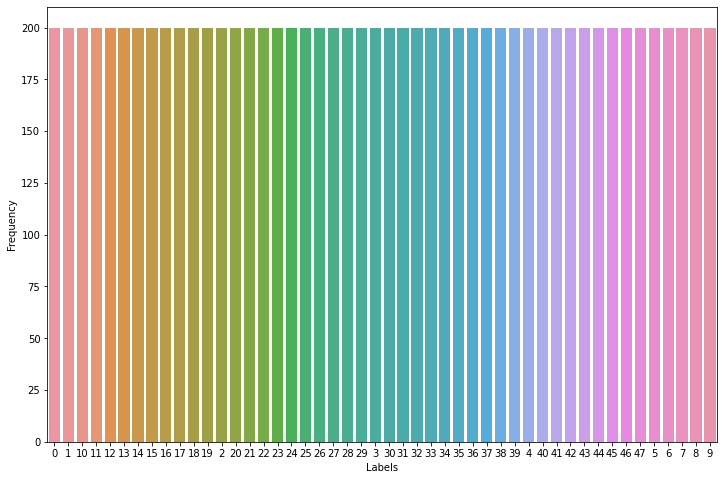

In [0]:
import seaborn as sns

fig_dims = (12, 8)
fig, ax = plt.subplots(figsize=fig_dims)

sns.barplot(x='Labels', y='Frequency', data=df_train_count, ax=ax) # Plotting unique label counts

From above plot, we can see that our train dataset has perfectly balanced labels. Now, let's see in the test set.

In [0]:
labels = df_test['Label'].unique()
labels_values = df_test['Label'].values 
values = []
for label in labels:
    count = 0
    for value in labels_values:
        if label == value:
            count += 1
    values.append(count)
df_test_count = pd.DataFrame({'Labels': labels, 'Frequency': values})

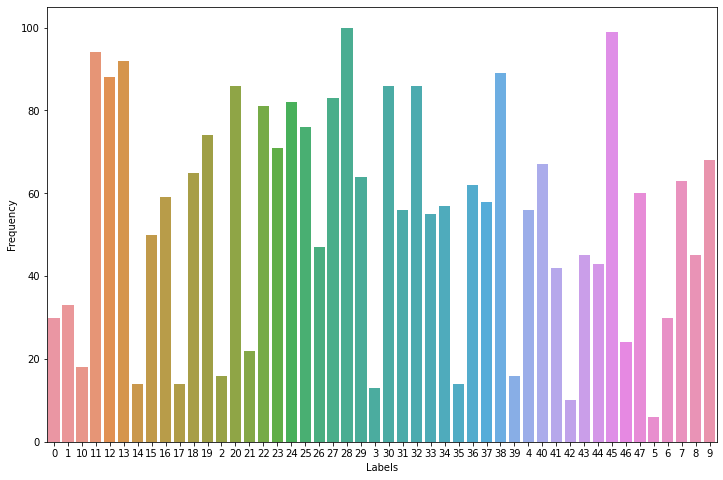

In [0]:
import seaborn as sns

fig_dims = (12, 8)
fig, ax = plt.subplots(figsize=fig_dims)

sns.barplot(x='Labels', y='Frequency', data=df_test_count, ax=ax) # Plotting unique label counts

Not perfect as train set, right? We have to be very careful while building our model because of this imbalance in the test data.

## Data generation and augmentation
Since, we are working on image dataset. So, storing all the images at a time will drain our memory and may kill our system. Therefore, we need to generate the image data in batch wise while training. For this, we have nice method called, `ImageDataGenerator` from `keras.preprocessing.image` library. Let's see how it works.

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Augmented for train_set
train_datagen = ImageDataGenerator(
        preprocessing_function=lambda x: (x/127.5) - 1.0,
        validation_split=0.2,
        shear_range=0.2,
        zoom_range=0.2
        )

test_datagen = ImageDataGenerator(
        preprocessing_function=lambda x: (x/127.5) - 1.0
        )

train_generator = train_datagen.flow_from_dataframe(
        dataframe=df_train, 
        directory=TRAIN_DATA_PATH,
        x_col="Data",
        y_col="Label",
        subset='training',
        class_mode="categorical",
        target_size=(150,150),
        batch_size=32
        )

valid_generator = train_datagen.flow_from_dataframe(
        dataframe=df_train, 
        directory=TRAIN_DATA_PATH,
        x_col="Data",
        y_col="Label",
        subset='validation',
        class_mode="categorical",
        target_size=(150,150),
        batch_size=32
        )

test_generator = test_datagen.flow_from_dataframe(
        dataframe=df_test,
        directory=TEST_DATA_PATH,
        x_col='Data',
        y_col='Label',
        class_mode='categorical',
        target_size=(150, 150),
        batch_size=32
        )

Found 7680 validated image filenames belonging to 48 classes.
Found 1920 validated image filenames belonging to 48 classes.
Found 2609 validated image filenames belonging to 48 classes.


## Model selection
Here, we are selecting the pretrained models from `keras.applications` library.

### InceptionNet Model

In [13]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

inception_model = InceptionV3(include_top = False, weights='imagenet')

87916544/87910968 [==============================] - 2s 0us/step


In [0]:
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Freezing all pretrained layers
# inception_model.trainable = False

# Replacing new layers with fully connected layers
inception_feature = inception_model.output
inception_feature = GlobalAveragePooling2D()(inception_feature)
inception_feature = Dense(512, activation='relu')(inception_feature)
inception_feature = Dense(512, activation='relu')(inception_feature)
output_layer = Dense(48, activation='softmax')(inception_feature)

# Creating new model with all above configuration
inception_model = Model(inputs=inception_model.input, outputs=output_layer)

# Compiling the model with different arguments
inception_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### MobileNet model



In [15]:
# Importing the MobileNetV2 model
from tensorflow.keras.applications.mobilenet import MobileNet 

# Initializing the model
mobile_model = MobileNet(include_top=False, weights='imagenet')

17227776/17225924 [==============================] - 0s 0us/step


In [0]:
# Freezing all the pretrained layers
# for layers in mobile_model.layers:
#     layers.trainable = False

# Replacing new layers with fully connected layers
mobile_feature = mobile_model.output
mobile_feature = GlobalAveragePooling2D()(mobile_feature)
mobile_feature = Dense(1024, activation='relu')(mobile_feature)
mobile_feature = Dense(512, activation='relu')(mobile_feature)
mobile_feature = Dense(512, activation='relu')(mobile_feature)
output_layer = Dense(48, activation='softmax')(mobile_feature)

# Creating new model with all above configuration
mobile_model = Model(inputs=mobile_model.input, outputs=output_layer)

# Compiling the model with different arguments
mobile_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

### DenseNet121 model



In [18]:
# Importing the MobileNetV2 model
from tensorflow.keras.applications import DenseNet121 

# Initializing the model
dense_model = DenseNet121(input_shape=(150, 150, 3),
                           include_top=False,
                           weights='imagenet')

29089792/29084464 [==============================] - 0s 0us/step


In [0]:
# Freezing all the pretrained layers
# dense_model.trainable = False

# Replacing new layers with fully connected layers
dense_feature = dense_model.output
dense_feature = GlobalAveragePooling2D()(dense_feature)
# dense_feature = Dense(1024, activation='relu')(dense_feature)
# dense_feature = Dense(512, activation='relu')(dense_feature)
dense_feature = Dense(512, activation='relu')(dense_feature)
output_layer = Dense(48, activation='softmax')(dense_feature)

# Creating new model with all above configuration
dense_model = Model(inputs=dense_model.input, outputs=output_layer)

# Compiling the model with different arguments
dense_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

### Simple CNN model


In [0]:
simple_model = Sequential()

simple_model.add(Conv2D(32, kernel_size=5, strides=2, activation='relu', input_shape=(150, 150, 3)))
simple_model.add(Conv2D(64, kernel_size=3, strides=1, activation='relu'))

simple_model.add(Flatten())

simple_model.add(Dense(128, activation='relu'))
simple_model.add(Dense(48, activation='softmax'))

simple_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### Generating model summary diagram
Let's visualize how above simple CNN looks like in the flow chart diagram form.

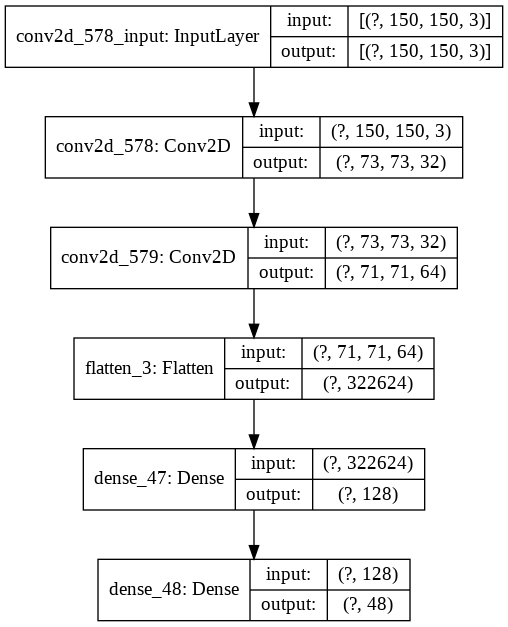

In [0]:
from tensorflow.keras.utils import plot_model

plot_model(
    simple_model,
    to_file='simple_cnn_model.png',
    show_shapes=True,
    show_layer_names=True
    )

### Custom CNN Model


In [0]:
cnn_model = Sequential()
cnn_model.add(Conv2D(filters=16, kernel_size=(5, 5), activation="relu", input_shape=(150, 150, 3)))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.25))
cnn_model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.25))
cnn_model.add(Conv2D(filters=64, kernel_size=(5, 5), activation="relu"))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.25))
cnn_model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.25))
cnn_model.add(Flatten())
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(64, activation='relu'))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(48, activation='softmax'))

cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

## Fit the model

In [21]:
TRAIN_STEP = train_generator.n // train_generator.batch_size
VALID_STEP = valid_generator.n // valid_generator.batch_size

mobile_model.fit_generator(
      train_generator,
      steps_per_epoch=TRAIN_STEP,
      epochs=5,
      validation_data=valid_generator,
      validation_steps=VALID_STEP
    )

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/5
240/240 [==============================] - 87s 364ms/step - loss: 3.6925 - accuracy: 0.0365 - val_loss: 18.5378 - val_accuracy: 0.0000e+00
Epoch 2/5
240/240 [==============================] - 86s 357ms/step - loss: 0.9512 - accuracy: 0.6901 - val_loss: 32.4610 - val_accuracy: 0.0151
Epoch 3/5
240/240 [==============================] - 86s 356ms/step - loss: 0.1519 - accuracy: 0.9617 - val_loss: 33.4508 - val_accuracy: 0.0599
Epoch 4/5
240/240 [==============================] - 86s 357ms/step - loss: 0.1398 - accuracy: 0.9672 - val_loss: 29.1630 - val_accuracy: 0.0620
Epoch 5/5
240/240 [==============================] - 85s 354ms/step - loss: 0.1051 - accuracy: 0.9768 - val_loss: 25.7922 - val_accuracy: 0.0615


## Model evaluation
Now, let's evaluate our model accuracy in the test datasets.


In [22]:
mobile_model.evaluate(test_generator)

82/82 [==============================] - 11s 129ms/step - loss: 4.9265 - accuracy: 0.7919


[4.926514148712158, 0.7918742895126343]

## Save model
We have successfully built the image classifier model with test accuracy of ~80%. Now, let's save the model for later use.

In [0]:
mobile_model.save('mobile_model.h5')

## Model prediction
Now, we have a trained model. Now, let's check how correctly it classifies the images as follows.

In [29]:
# Taking 4th row of test data for prediction
test_labels = df_test['Label'].values[4]
images_name = [df_test['Data'].values[4]]

image_list = []

# Loading the image repect to label and transforming into array
for i, image_name in enumerate(images_name):
    img = image.load_img('test/testset/' + image_name, target_size=(150,150,3))
    img = image.img_to_array(img)
    img = img/255.
    image_list.append(img)
image_array = np.array(image_list)

# Predict the image to it's label
predicted_prob = mobile_model.predict(image_array)

# Converting into actual label form
predicted_labels = np.argmax(predicted_prob, axis=1)

# Printing the accuracy between actual and predicted label
print(test_labels, predicted_labels)

10 [0]


## Model performance

No handles with labels found to put in legend.


[[0.9425154328346252, 0.9363425970077515, 0.9591049551963806, 0.9938271641731262, 0.9907407164573669]]


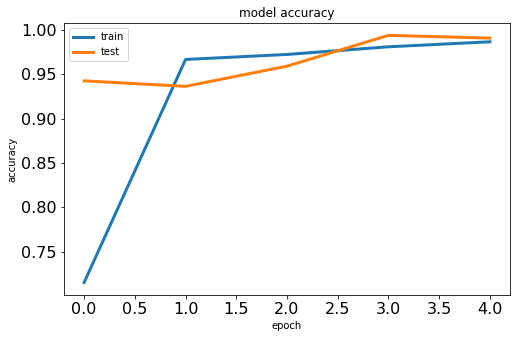

No handles with labels found to put in legend.


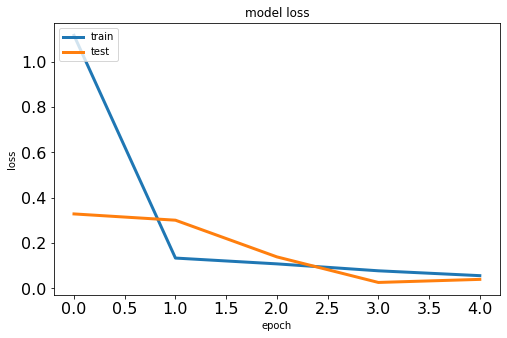

In [0]:
print(test_accuracy)
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.plot(train_accuracy[0], linewidth=3)
plt.plot(test_accuracy[0], linewidth=3)

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.figure(figsize=(8, 5))
plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.plot(train_losses[0], linewidth=3)
plt.plot(test_losses[0], linewidth=3)

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')

plt.show()